# Задание 2. Метод кластеризации K-means

## 0. Датасет

### Описание

Для анализа выбрад датасет "Customer Personality Analysis" ([Источник](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis)).

Датасет содержит следующие атрибуты

| Атрибут           | Тип       | Характеристика                                     |      
|-------------------|-----------|----------------------------------------------------| 
| ID                | численный | Уникальный идентификатор покупателя                |
| Year_Birth        | численный | Год рождения                                       |
| Education         | строковый | Уровень образования                                | 
| Marital_Status    | строковый | Семейное положение                                 |
| Income            | численный | Годовой семейный доход                             |
| Kidhome           | численный | Количество детей в семье                           |
| Teenhome          | численный | Количество подростков в семье                      |
| Dt_Customer       | строковый | Дата регистрации клиента в компании                |
| Recency           | численный | Количество дней с момента последней покупки        |
| MntWines          | численный | Сумма, потраченая на вино за последние 2 года      |
| MntFruits         | численный | Сумма, потраченая на фрукты за последние 2 года    |
| MntMeatProducts   | численный | Сумма, потраченая на мясо за последние 2 года      |
| MntSweetProducts  | численный | Сумма, потраченая на сладкое за последние 2 года   |
| NumWebPurchases   | численный | Количество покупок, сделанных через сайт компании  |
| NumStorePurchases | численный | Количество покупок, сделанных в магазинах компании |


Остальные атрибуты опущены из-за их большого количества.

In [1]:
import pandas as pd
df = pd.read_csv("../data/marketing_campaign.csv", sep="\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### Преобразование

Оставим только численные поля из описанных выше (кроме ID, который не несет никакой смысловой нагрузки).

In [2]:
df = df[["Year_Birth", "Income", "Kidhome", "Teenhome", "Dt_Customer", "Recency", "MntWines", "MntFruits", "MntMeatProducts", "MntSweetProducts", "NumWebPurchases", "NumStorePurchases"]]
df.head()

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntSweetProducts,NumWebPurchases,NumStorePurchases
0,1957,58138.0,0,0,04-09-2012,58,635,88,546,88,8,4
1,1954,46344.0,1,1,08-03-2014,38,11,1,6,1,1,2
2,1965,71613.0,0,0,21-08-2013,26,426,49,127,21,8,10
3,1984,26646.0,1,0,10-02-2014,26,11,4,20,3,2,4
4,1981,58293.0,1,0,19-01-2014,94,173,43,118,27,5,6


In [3]:
df.size

26880

Поскольку покупательные характеристики (Mnt...) указаны только за последние 2 года, возьмем покупателей, которые были активны за последний год.

In [4]:
df[df["Recency"] <= 365].size

26880

Делаем вывод, что датасет содержит актуальные данные.

## 1. Новые атрибуты

Добавим новые атрибуты:
* Возраст покупателя в годах
* Количество дней с момента регистрации покупателя в компании

Для вычисления этих атрибутов нужна точка отсчета. Пример за нее наиболее позднюю дату в датасете.

In [5]:
from datetime import datetime, timedelta

In [6]:
dates = sorted(map(lambda x: datetime.strptime(x, "%d-%m-%Y"), df["Dt_Customer"].values))
print("Самая ранняя дата", dates[0])
print("Самая поздняя дата", dates[-1])

Самая ранняя дата 2012-07-30 00:00:00
Самая поздняя дата 2014-06-29 00:00:00


In [7]:
now = dates[-1]
df = df.assign(age=lambda data: now.year - data["Year_Birth"]);

In [8]:
df["registered_for_days"] = df["Dt_Customer"].map(lambda x: now - datetime.strptime(x, "%d-%m-%Y")).map(lambda data: data.days)

От строковых полей Year_Birth, Dt_Customer можно избавиться

In [9]:
df.drop(["Year_Birth", "Dt_Customer"], axis=1, inplace=True)

Получаем таблицу вида

In [10]:
df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntSweetProducts,NumWebPurchases,NumStorePurchases,age,registered_for_days
0,58138.0,0,0,58,635,88,546,88,8,4,57,663
1,46344.0,1,1,38,11,1,6,1,1,2,60,113
2,71613.0,0,0,26,426,49,127,21,8,10,49,312
3,26646.0,1,0,26,11,4,20,3,2,4,30,139
4,58293.0,1,0,94,173,43,118,27,5,6,33,161


## 2. Очистка датасета

Определим, содержит ли датасет пропущенные значения. Для этого вычислим строки, содержащие хотя бы 1 пропущенное значение (None, numpy.NaN)

In [11]:
(df.isna().sum(axis = 1) > 0).sum()

24

Удалим строки, содержащие пропущенные значения.

In [12]:
df = df.dropna()
df.size

26592

Проверим наличие выбросов и удалим их

In [13]:
import numpy as np

In [14]:
threshold = 2.22

for column in df.columns:
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    outliers = np.abs((df[column] - df[column].median()) / IQR) < threshold
    df[column] = df[column].where(outliers, np.nan)

df = df.dropna()
df.size

20640

## 3. Графики зависимостей

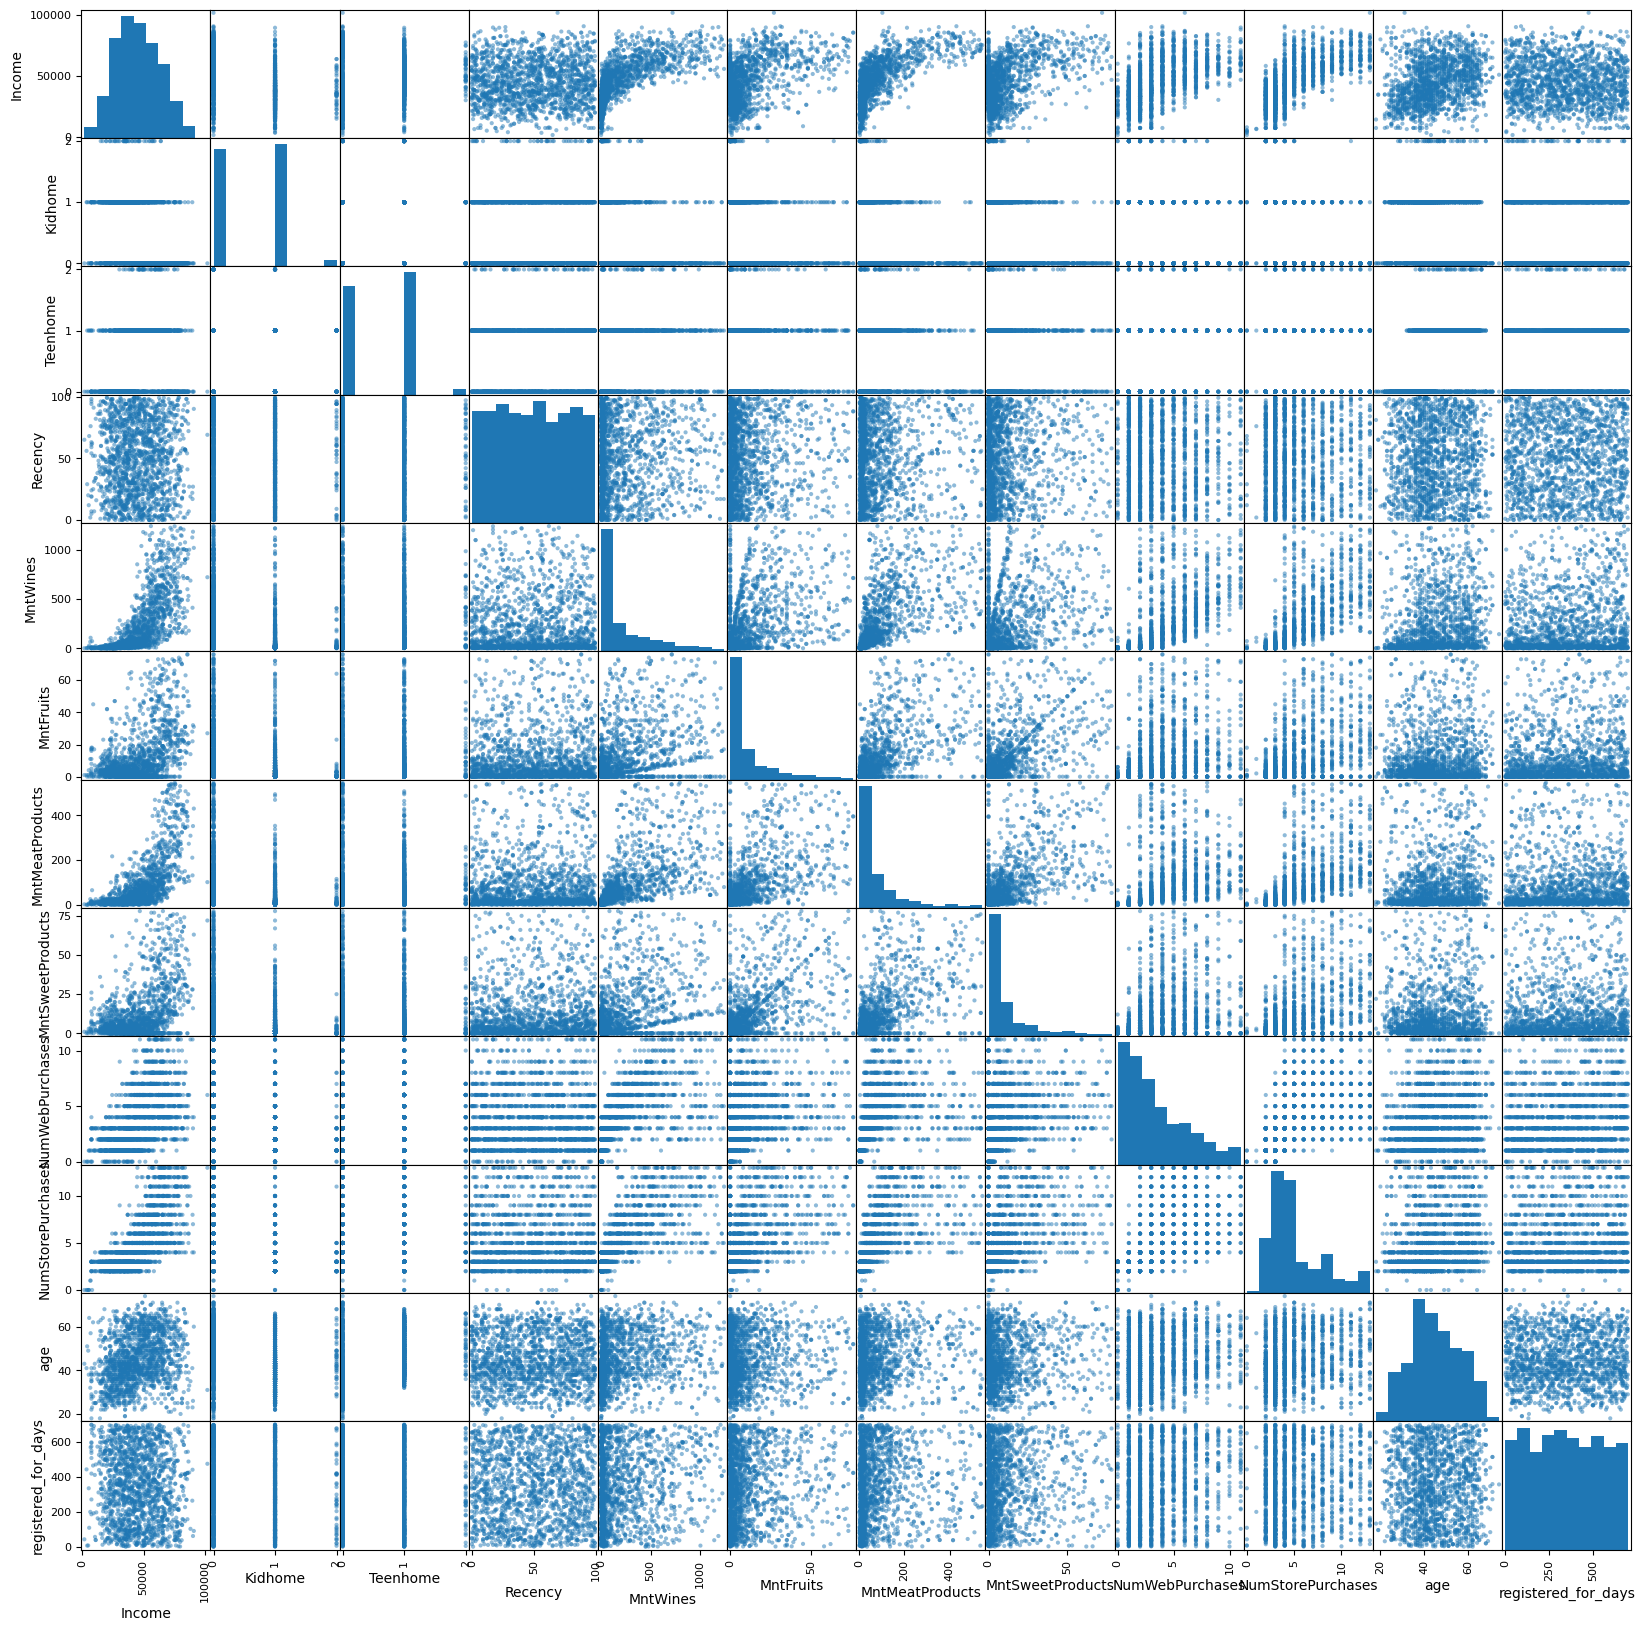

In [18]:
pd.plotting.scatter_matrix(df, figsize=(20, 20));

Выборочно построим графики зависимостей одной переменной от другой.

In [20]:
import matplotlib.pyplot as plt

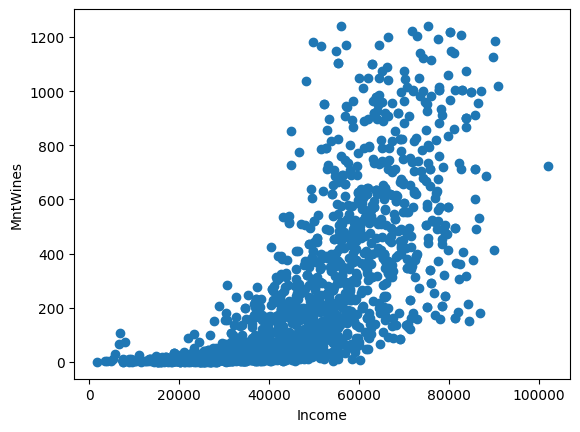

In [24]:
plt.scatter(df["Income"], df["MntWines"]);
plt.xlabel("Income");
plt.ylabel("MntWines");

Предварительно наблюдаем 2 кластера

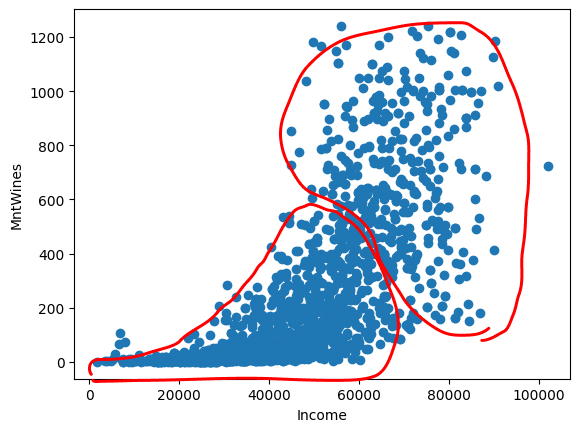

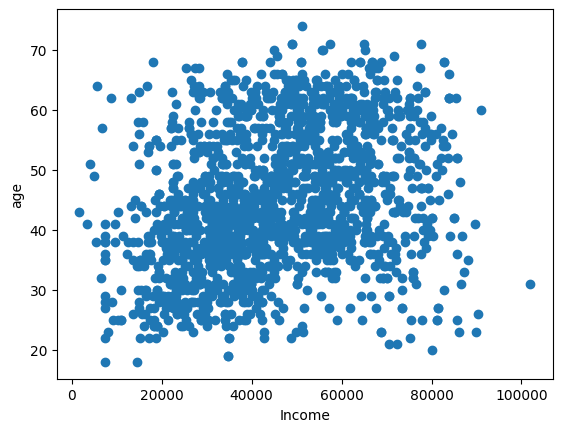

In [25]:
plt.scatter(df["Income"], df["age"]);
plt.xlabel("Income");
plt.ylabel("age");

Предварительно наблюдаем 2 кластера

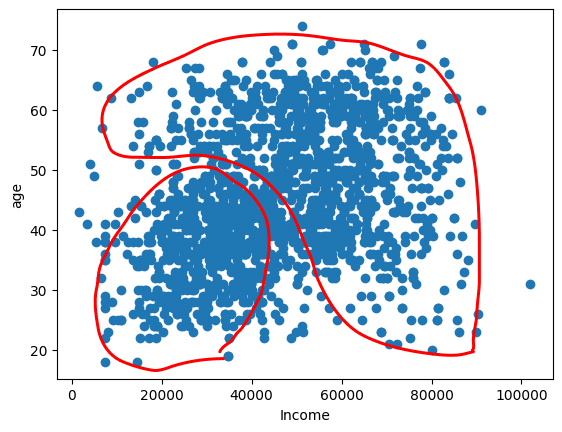

Ярковыраженные группы в данном датасете найти не удалось.

## 4. Метод кластеризации K-means

### Нормализация данных

In [26]:
from sklearn import preprocessing

In [38]:
df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntSweetProducts,NumWebPurchases,NumStorePurchases,age,registered_for_days
1,46344.0,1,1,38,11.0,1.0,6.0,1.0,1.0,2,60.0,113
2,71613.0,0,0,26,426.0,49.0,127.0,21.0,8.0,10,49.0,312
3,26646.0,1,0,26,11.0,4.0,20.0,3.0,2.0,4,30.0,139
4,58293.0,1,0,94,173.0,43.0,118.0,27.0,5.0,6,33.0,161
5,62513.0,0,1,16,520.0,42.0,98.0,42.0,6.0,10,47.0,293


In [42]:
normalized = preprocessing.MinMaxScaler().fit_transform(df)
df_normalized = pd.DataFrame(normalized, index=df.index, columns=df.columns)
df_normalized.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntSweetProducts,NumWebPurchases,NumStorePurchases,age,registered_for_days
1,0.445072,0.5,0.5,0.383838,0.008864,0.013158,0.011009,0.012821,0.090909,0.153846,0.750000,0.161660
2,0.697157,0.0,0.0,0.262626,0.343272,0.644737,0.233028,0.269231,0.727273,0.769231,0.553571,0.446352
3,0.248563,0.5,0.0,0.262626,0.008864,0.052632,0.036697,0.038462,0.181818,0.307692,0.214286,0.198856
4,0.564276,0.5,0.0,0.949495,0.139404,0.565789,0.216514,0.346154,0.454545,0.461538,0.267857,0.230329
5,0.606375,0.0,0.5,0.161616,0.419017,0.552632,0.179817,0.538462,0.545455,0.769231,0.517857,0.419170


### Выбор k

In [44]:
from sklearn.cluster import KMeans

In [47]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i, n_init=10) for i in Nc]

In [48]:
score = [kmeans[i].fit(df_normalized).score(df_normalized) for i in range(len(kmeans))]

Значения score показывают, насколько далеки наши наблюдения от центра кластера. Хотим, чтобы это значение баллов было около 0. Большое положительное или большое отрицательное значение указывает на то, что центр кластера находится далеко от наблюдений.

Основываясь на этих значениях баллов, мы строим кривую Elbow, чтобы решить, какой размер кластера является оптимальным.

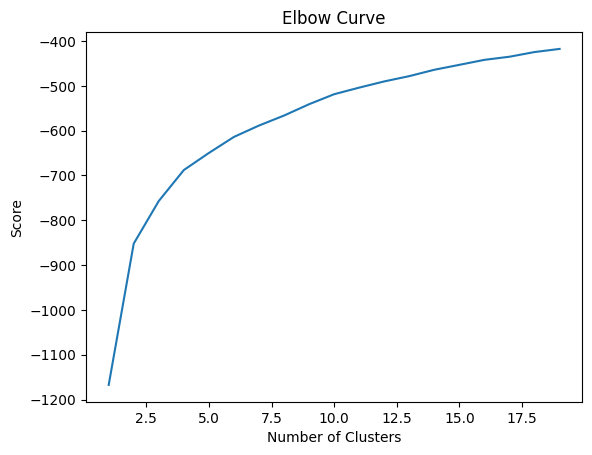

In [49]:
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

В данном случае точка изгиба наблюдается при количестве кластеров, равном 4. Примем k = 4.

In [51]:
kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(df_normalized)

KMeans(n_clusters=4, n_init=10)

Получим количество меток образованных кластеров

In [52]:
len(kmeans.labels_)

1720

Добавит атрибут кластера в датасет

In [54]:
df['cluster'] = kmeans.labels_
df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntSweetProducts,NumWebPurchases,NumStorePurchases,age,registered_for_days,cluster
1,46344.0,1,1,38,11.0,1.0,6.0,1.0,1.0,2,60.0,113,2
2,71613.0,0,0,26,426.0,49.0,127.0,21.0,8.0,10,49.0,312,0
3,26646.0,1,0,26,11.0,4.0,20.0,3.0,2.0,4,30.0,139,1
4,58293.0,1,0,94,173.0,43.0,118.0,27.0,5.0,6,33.0,161,0
5,62513.0,0,1,16,520.0,42.0,98.0,42.0,6.0,10,47.0,293,0


### Интерпретация результатов

Посмотрим на кластеров

In [55]:
import seaborn as sns

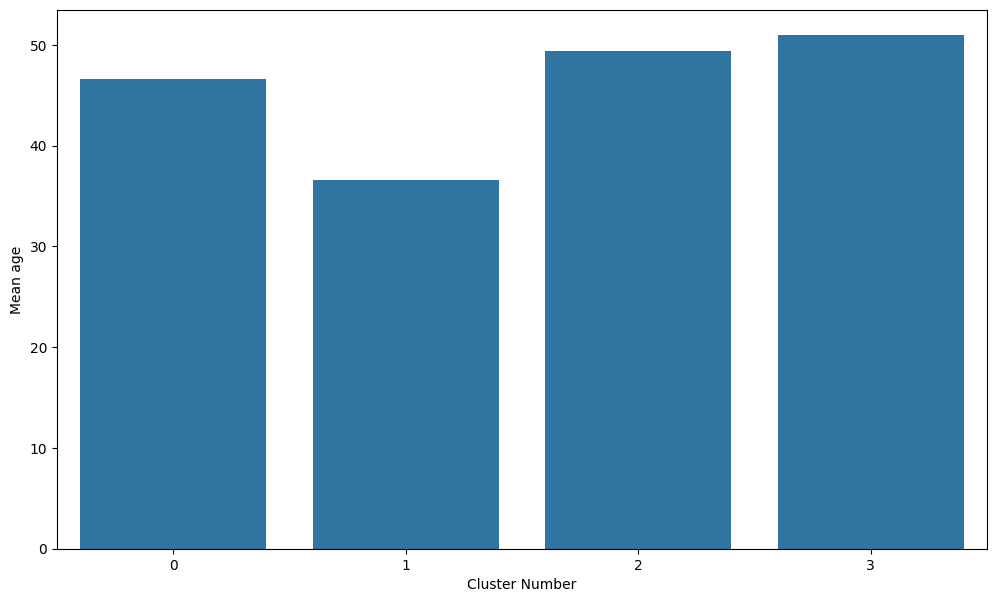

In [65]:
plt.figure(figsize=(12, 7))
axis = sns.barplot(
    x=np.arange(0, 4, 1),
    y=df.groupby(['cluster']).mean()["age"].values
)
x = axis.set_xlabel("Cluster Number")
x = axis.set_ylabel("Mean age")

По среднему возрасту выделяется только один кластер (0)

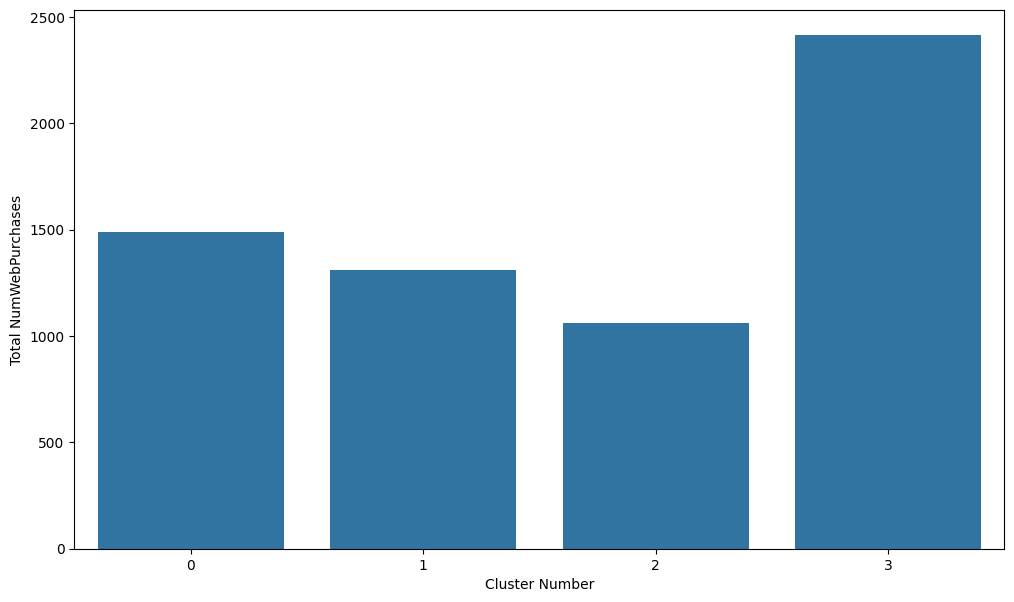

In [67]:
plt.figure(figsize=(12, 7))
axis = sns.barplot(
    x=np.arange(0, 4, 1),
    y=df.groupby(['cluster']).sum()["NumWebPurchases"].values
)
x = axis.set_xlabel("Cluster Number")
x = axis.set_ylabel("Total NumWebPurchases")

По общему количеству покупок на сайте наблюдаем один ярко выраженный кластер (3)

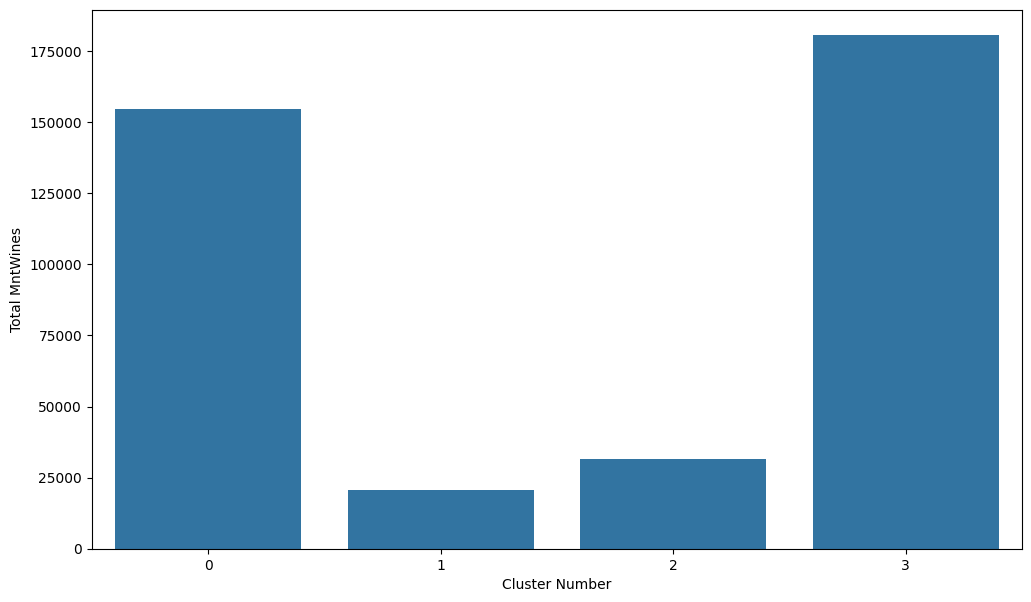

In [68]:
plt.figure(figsize=(12, 7))
axis = sns.barplot(
    x=np.arange(0, 4, 1),
    y=df.groupby(['cluster']).sum()["MntWines"].values
)
x = axis.set_xlabel("Cluster Number")
x = axis.set_ylabel("Total MntWines")

По общей сумме, потраченной на вино, видим 2 кластера (0, 3), которые существенно превосходят остальные

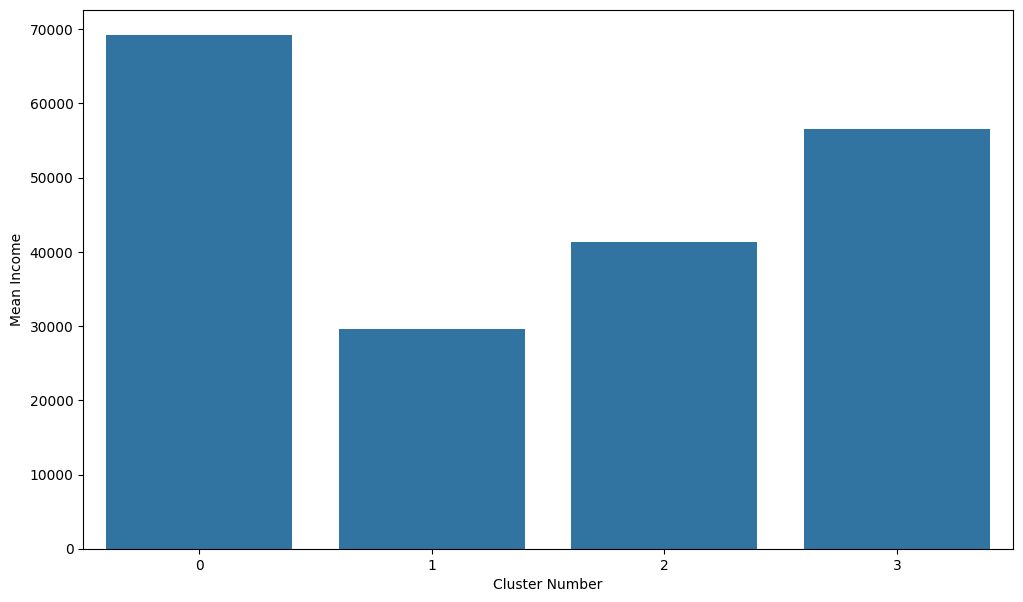

In [69]:
plt.figure(figsize=(12,7))
axis = sns.barplot(
    x=np.arange(0, 4, 1),
    y=df.groupby(['cluster']).mean()["Income"].values
)
x = axis.set_xlabel("Cluster Number")
x = axis.set_ylabel("Mean Income")

По среднему семейному доходу наблюдаем 4 кластера, которые образуют "ступеньки", если отсортировать значения - средний доход равномерно растет от кластера к кластеру.

## Вывод

Был опробован метод кластеризации K-means. Для полученных кластеров проведен выборочный анализ, для некоторых характеристик кластеры существенно отличаются между собой.